In [1]:
# 8.4. Generating Images with Variational Autoencoders (VAE)

## 8.4.1 Sampling from latent spaces of images
## 8.4.2 Concept vectors for image editing
## 8.4.3 VAE

In [2]:
### 8.4.3 VAE code

# paper : https://arxiv.org/pdf/1312.6114.pdf


# 용어 정리

- 잠재변수(Latent Variable)는 구성개념(Construct)이 직접적으로 관찰되거나 측정이 되지 않는 변수를 의미한다.
- encode, decode , 암호화/부화화, 암호화 해제~.. 아래 그림 예시 8.12
- latent vector space, concept vectors
- randomly sample
- normal distribution

# VAE 설명

- augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces.

- turns the image into the parameters of a statistical distribution: a mean and a variance.

- randomness of this process should be taken into accounting during encoding and decoding

Figure 8.13

1. An encoder module turns the input samples `input_img` into two parameters in a latent space of representations, `z_mean` and `z_log_variance`

2. Randomly sample a point `z` from the latent normal distribution that's assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where `epsilon` is a random tensor of small values ((((check))))

3. A decoder module maps this point in the latent space back to the original input image.

## loss functions

(1) `reconstruction loss` : forces the decoded samples to match the initial inputs

(2) `regularization loss` : helps learn well-formed latent spaces and reduce overfitting


# sudo of implementations of a VAE

z_mean, z_log_variance = encoder(input_img)

z = z_mean + exp(z_log_variance) * epsilon

reconstructed_img = decode(z)

model = Model(input_img, reconstructed_img)

In [54]:
## 8.23 VAE encoder network

import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28,28,1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape = img_shape)
x = layers.Conv2D(32,3,padding='same',activation='relu')(input_img)
# layers.Conv2D https://stackoverflow.com/questions/43624625/why-do-we-have-to-specify-output-shape-during-deconvolution-in-tensorflow/43624992#43624992

x = layers.Conv2D(64,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)


shape_before_flattening = K.int_shape(x) # return tuple of integers of shape of x

x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Q1. how to match these values to real mean and var values of z? let me see the loss function

In [55]:
## 8.24 latent_space_sampling function

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],latent_dim),mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [56]:
## 8.25 VAE decoder network, mapping latent space points to imgaes

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
# np.prod = https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.prod.html
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32,3,padding='same',activation='relu',strides=(2,2))(x)
# output shape = https://stackoverflow.com/questions/43624625/why-do-we-have-to-specify-output-shape-during-deconvolution-in-tensorflow/43624992#43624992
x = layers.Conv2D(1,3,padding='same',activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)


In [66]:
z_decoded.shape

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(1)])

In [57]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 12544)             37632     
_________________________________________________________________
reshape_4 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


In [58]:
## 8.26 Custom layer used to compute the VAE loss

class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x,z_decoded)
        kl_loss   = -5e-4*K.mean(1+z_log_var-K.square(z_mean)-K.exp(z_log_var),axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x,z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img,z_decoded]) #check

In [59]:
## 8.27 Training the VAE

from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop',loss=None) 
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Output "custom_variational_layer_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_5" during training.
  


In [65]:
y.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

In [28]:

(x_train,_),(x_test,y_test) = mnist.load_data()

x_train = x_train.astype('float32') /255.
x_train = x_train.reshape(x_train.shape+(1,)) # check
x_test = x_test.astype('float32') /255.
x_test = x_test.reshape(x_test.shape+(1,))

In [67]:
vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size,validation_data=(x_test,None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5980s 100ms/step - loss: 20595.6153 - val_loss: 0.1969
Epoch 2/10
60000/60000 [==============================] - 5761s 96ms/step - loss: 0.1955 - val_loss: 0.1929
Epoch 3/10
 9984/60000 [===>..........................] - ETA: 1:15:36 - loss: 0.1927

KeyboardInterrupt: 

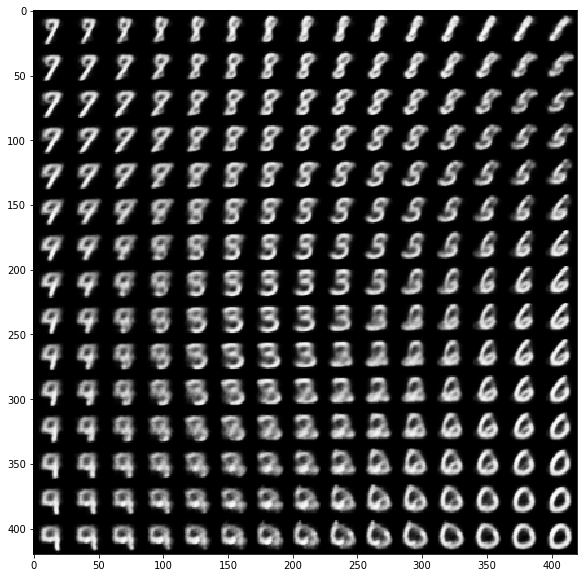

In [69]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n=15
digit_size = 28
figure = np.zeros((digit_size*n,digit_size*n))
grid_x = norm.ppf(np.linspace(0.05,0.95,n))
grid_y = norm.ppf(np.linspace(0.05,0.95,n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi,yi]])
        z_sample = np.tile(z_sample,batch_size).reshape(batch_size,2)
        x_decoded = decoder.predict(z_sample, batch_size = batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i+1)*digit_size, j*digit_size:(j+1)*digit_size] = digit
        
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap ='Greys_r')
plt.show()

        